# Telegram bot of Bitcoin price

## List of contents

*   Overview
*   Step 1: Install the libraries
*   Step 2: Make real-time price bot
*   Step 3: Make main bot
*   The Final Product
*   Conclusion

## Overview

Building a Telegram bot that can give the user the history of the Bitcoin price is one of the most interesting and at the same time the most common ideas for implementing Telegram bots. In this notebook, a Telegram bot is built that provides the user with the price of Bitcoin on a specific date and time. The user announces this time to the robot in a message.

## **Step 1:** Install the libraries

In [ ]:
pip install python-telegram-bot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
pip install requests

In [ ]:
pip install nest_asyncio

In [ ]:
pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 22.4 MB/s eta 0:00:00




---



## **Step 2:** Make real-time price bot

First of all, we need to build a Telegram bot that will give the user the price of Bitcoin in real time. Basically, this robot displays the price of Bitcoin to the user at the same time as requested (in live form).

In [ ]:
import requests
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes
import asyncio

# Replace 'YOUR_TOKEN' with your bot's API token
TOKEN = '7982112646:AAHJkHiRuvFW4YCDem0u'

async def get_bitcoin_price():
    response = requests.get('https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd')
    data = response.json()
    return data['bitcoin']['usd']

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Welcome! Use /price to get the current Bitcoin price.')

async def price(update: Update, context: ContextTypes.DEFAULT_TYPE):
    btc_price = await get_bitcoin_price()
    await update.message.reply_text(f'The current Bitcoin price is ${btc_price}.')

async def main():
    application = ApplicationBuilder().token(TOKEN).build()

    # Add command handlers
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("price", price))

    # Start the Bot
    await application.run_polling()

# Check if the event loop is already running
if __name__ == '__main__':
    asyncio.run(main())

By sending (**/start**), the user receives a message from the robot, during which the user is informed to enter the next command. By entering the (**/price**) command, the user receives the price of Bitcoin at the time of sending the message.

### **Output:**

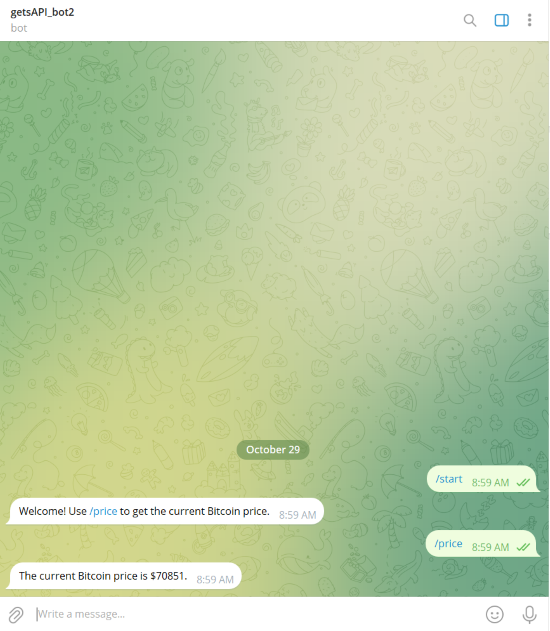



---



## **Step 3:** Make main bot

To make the main robot that is responsible for sending the price at a certain time, you should try this way:

In [ ]:
import ccxt
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes
from datetime import datetime

API_KEY = '7982112646:AAHJkHiRuvFW4YCDem0u'  # Token API Telegram
# connect to exchange
exchange = ccxt.kraken()

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text('Send /price YYYY-MM-DD HH:MM to get the Bitcoin price on that date and time.')

async def get_price(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    print(f"Received command: {update.message.text}")
    print(f"Received arguments: {context.args}")

    # Arguments
    if len(context.args) == 2:
        date_time_str = ' '.join(context.args)
    elif len(context.args) == 1:
        date_time_str = context.args[0]
    else:
        await update.message.reply_text('Please provide a date and time in the format YYYY-MM-DD HH:MM.')
        return

    try:
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
        timestamp = int(date_time.timestamp()) * 1000  # convert to Mili-Second

        # get OHLCV of historial Bitcoin prices
        ohlcv = exchange.fetch_ohlcv('BTC/USD', '1h', since=timestamp - (60 * 60 * 1000), limit=24)

        # Find the closest price to the specified date and time
        closest_price = None
        closest_diff = float('inf')

        for entry in ohlcv:
            entry_timestamp = entry[0]
            diff = abs(entry_timestamp - timestamp)

            if diff < closest_diff:
                closest_diff = diff
                closest_price = entry[4]

        if closest_price is not None:
            await update.message.reply_text(f' Bitcoin price in {date_time_str} was nearest ${closest_price:.2f} ')
        else:
            await update.message.reply_text('No data found for this time.')

    except ValueError:
        await update.message.reply_text('Please send a date and time in the format /price YYYY-MM-DD HH:MM.')
    except Exception as e:
        await update.message.reply_text(f'Have an error: {e}')

async def main():
    app = ApplicationBuilder().token(API_KEY).build()

    app.add_handler(CommandHandler("start", start))
    app.add_handler(CommandHandler("price", get_price))

    await app.run_polling()

if __name__ == '__main__':
    import asyncio
    asyncio.run(main())


### **Output:**

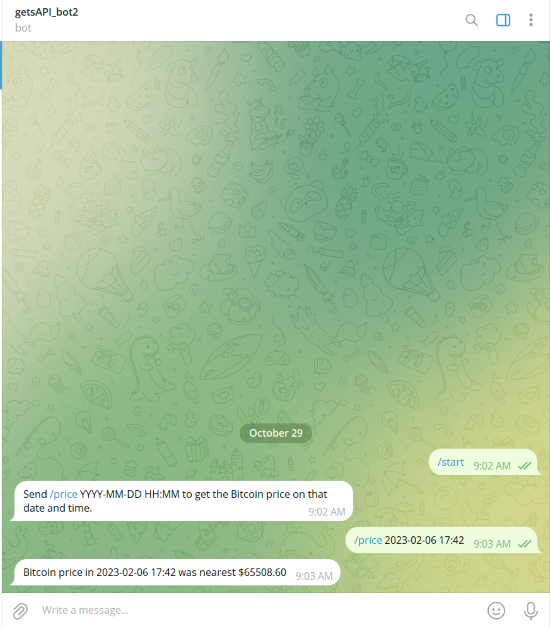



---



## The Final Product
The final product design by buttons to have a user friendly environment.

In [ ]:
import ccxt
from telegram import Update, ReplyKeyboardMarkup
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes, MessageHandler, filters
from datetime import datetime

API_KEY = '7982112646:AAHJkHiRuvFW4YCDem0u'  # Token API
chat_ids = set()  # To store unique chat IDs

# Connect to exchange
exchange = ccxt.kraken()

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    keyboard = [['Bitcoin Price', 'About Us']]
    reply_markup = ReplyKeyboardMarkup(keyboard, resize_keyboard=True)

    await update.message.reply_text('Hello, Please choose a button:', reply_markup=reply_markup)

async def about_us(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    about_text = "We are a cryptocurrency bot providing price information and insights. " \
                 "Our mission is to empower users with real-time data. For more info, visit our website."
    await update.message.reply_text(about_text)

async def get_price(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    print(f"Received command: {update.message.text}")
    print(f"Received arguments: {context.args}")

    if len(context.args) == 2:
        date_time_str = ' '.join(context.args)
    elif len(context.args) == 1:
        date_time_str = context.args[0]
    else:
        await update.message.reply_text('Please provide a date and time in the format YYYY-MM-DD HH:MM.')
        return

    try:
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
        timestamp = int(date_time.timestamp()) * 1000  # convert to milliseconds

        ohlcv = exchange.fetch_ohlcv('BTC/USD', '1h', since=timestamp - (60 * 60 * 1000), limit=24)

        closest_price = None
        closest_diff = float('inf')

        for entry in ohlcv:
            entry_timestamp = entry[0]
            diff = abs(entry_timestamp - timestamp)

            if diff < closest_diff:
                closest_diff = diff
                closest_price = entry[4]

        if closest_price is not None:
            await update.message.reply_text(f'Bitcoin Price in {date_time_str} near to ${closest_price:.2f}.')
        else:
            await update.message.reply_text('No data found for this time.')

    except ValueError:
        await update.message.reply_text('Please send a date and time in the format /price YYYY-MM-DD HH:MM.')
    except Exception as e:
        await update.message.reply_text(f'Have an error: {e}')

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    if update.message.text == 'Bitcoin Price':
        await update.message.reply_text('Please send a date and time in the format /price YYYY-MM-DD HH:MM.')
    elif update.message.text == 'About Us':
        await about_us(update, context)
    else:
        await update.message.reply_text('Please choose a button.')

async def main():
    app = ApplicationBuilder().token(API_KEY).build()

    app.add_handler(CommandHandler("start", start))
    app.add_handler(CommandHandler("price", get_price))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))

    await app.run_polling()

if __name__ == '__main__':
    import asyncio
    asyncio.run(main())

### **Output:**

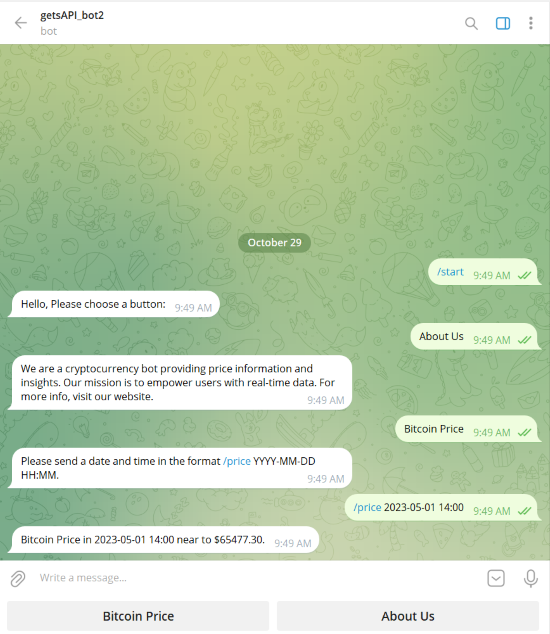

To use this product, you can click on the "About Us" button and get information about the content of this bot.

In addition, you can see the value of this cryptocurrency at the requested time by clicking on the "Bitcoin price" button and continuing to enter the time in the mentioned format.

## Conclusion

In this notebook, it was investigated how to make a Telegram bot that provides the price of Bitcoin. Building a bitcoin price presenting bot can be very useful in analyzing and predicting the price of this cryptocurrency.